<a href="https://colab.research.google.com/github/ricky-kiva/dl-deep-applied/blob/main/tf_1_eu_money_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **European Money Denominations Classifier**

*   !wget: download dataset  
  *   --quiet: surpress progress message
  *   -o: set output dir

*   !tar: command regarding archives operation
  *   -x: extract files
  *   -z: ensure archive to be decompressed is in gzip (*.gz*)
  *   -f: use specified archive file to be extracted
  *   -C: specify extract directory
  *   --exclude '.*': exclude files that starts with dot (.) to be extracted




Initiate directory for dataset

In [1]:
import os

data_path = './data'

if not os.path.exists(data_path):
  os.makedirs(data_path)

Import dataset

In [2]:
archive_ext = '.tar.gz'

def download_dataset_by_type(_type, fn, link):

  download_path = os.path.join(data_path, fn)
  dir = os.path.join(data_path, _type)

  if not os.path.exists(dir):
    os.makedirs(download_path)

    !wget --quiet -O {download_path + archive_ext} {link}
    !tar -xzf {download_path + archive_ext} -C {data_path} --exclude '.*'

    os.rename(download_path, dir)
    os.remove(download_path + archive_ext)

  return dir

# import training data
fn_train, link_train = 'train_data_keras', 'https://cocl.us/DL0320EN_TRAIN_TAR_KERAS'
train_dir = download_dataset_by_type('train', fn_train, link_train)

# import validation data
fn_validation, link_validation = 'validation_data_keras', 'https://cocl.us/DL0320EN_VALID_TAR_KERAS'
validation_dir = download_dataset_by_type('validation', fn_validation, link_validation)

# import test data
fn_test, link_test = 'test_data_keras', 'https://cocl.us/DL0320EN_TEST_TAR_KERAS'
test_dir = download_dataset_by_type('test', fn_test, link_test)

Data exploration

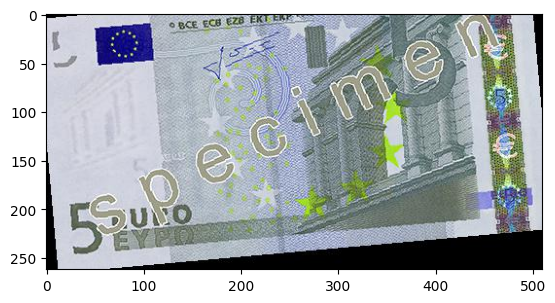

In [3]:
from IPython.lib.display import join
import matplotlib.pyplot as plt
from PIL import Image

def get_image_by_class(path, _class, fn):
  img_path = os.path.join(path, f'{_class}/{fn}.jpeg')
  return Image.open(img_path)

# plot train image 0 class 5
img = get_image_by_class(train_dir, 5, 0)
plt.imshow(img)

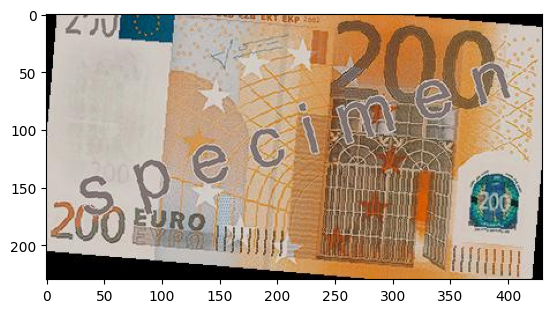

In [4]:
# plot train image 52 class 200
img = get_image_by_class(train_dir, 200, 52)
plt.imshow(img)

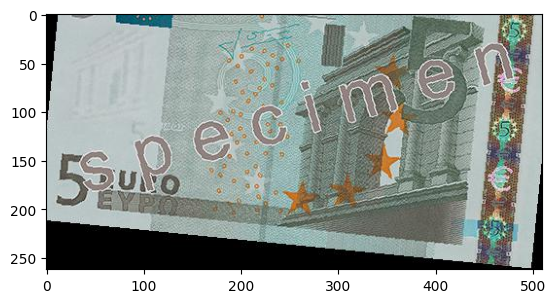

In [5]:
# plot validation image 0 class 5
img = get_image_by_class(validation_dir, 5, 0)
plt.imshow(img)

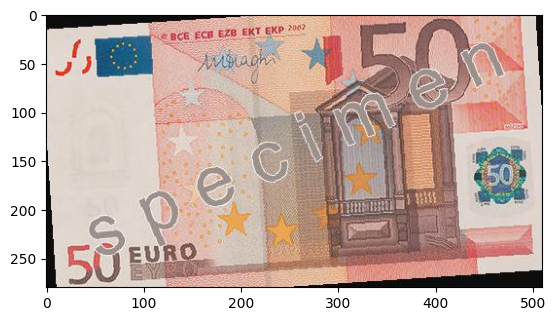

In [6]:
# plot validation image 36 class 50
img = get_image_by_class(validation_dir, 50, 36)
plt.imshow(img)

Make ImageDataGenerator for train data

In [7]:
from keras.preprocessing.image import ImageDataGenerator

TARGET_SIZE = (224, 224)
BATCH_SIZE = 5
CLASSES = ['5', '10', '20', '50', '100', '200', '500']
RANDOM_SEED = 0

train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    seed=RANDOM_SEED) # same seed will result to same augmented images each train

Found 70 images belonging to 7 classes.


Make ImageDataGenerator for validation data

In [8]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    seed=RANDOM_SEED)

Found 70 images belonging to 7 classes.


Function to get image in generator by batch

In [9]:
import numpy as np

def get_generator_image_by_batch(generator, batch, index):
  return generator.next()[batch][index].astype(np.uint8)

# gen_img = get_generator_image_by_batch(validation_generator, 0, 0)
# plt.imshow(gen_img)

Test training generator sample batch 0

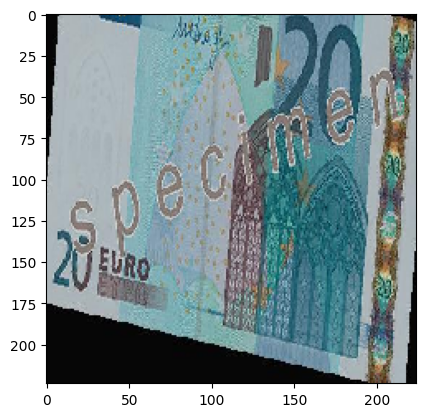

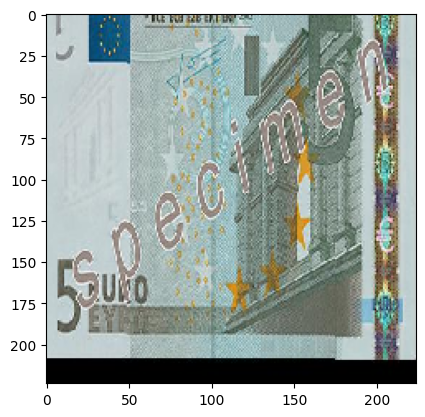

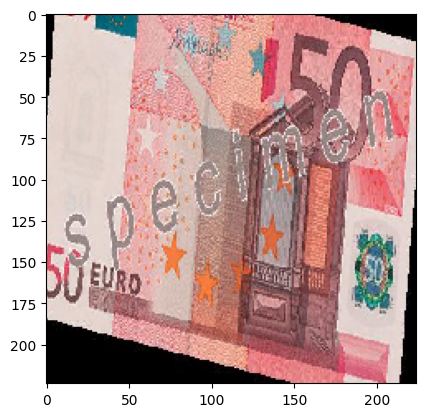

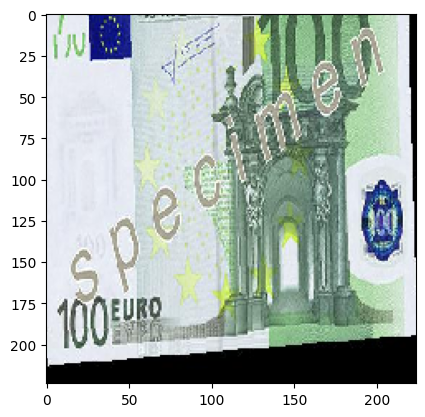

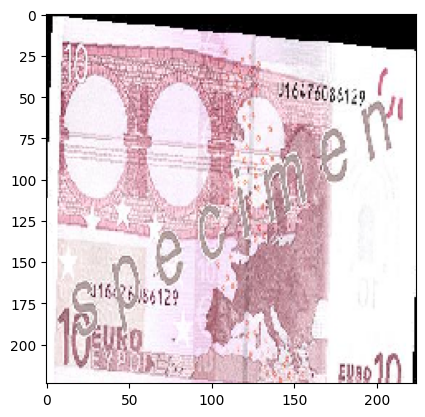

In [10]:
def visualize_generator_samples_by_batch(generator, batch):
  for i in range(generator.batch_size):
    image = get_generator_image_by_batch(generator, batch, i)
    plt.imshow(image)
    plt.show()

visualize_generator_samples_by_batch(train_generator, 0)

Test validation generator sample batch 0

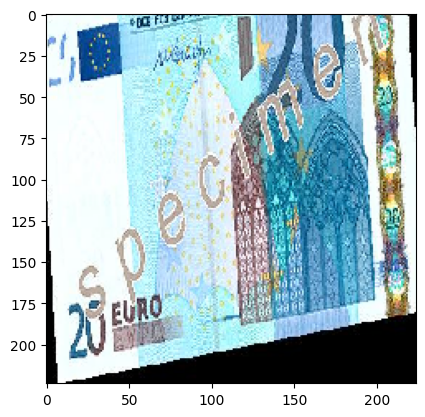

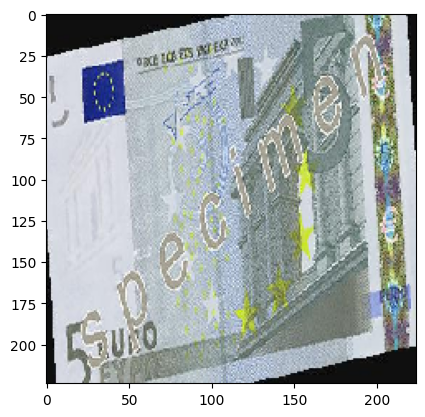

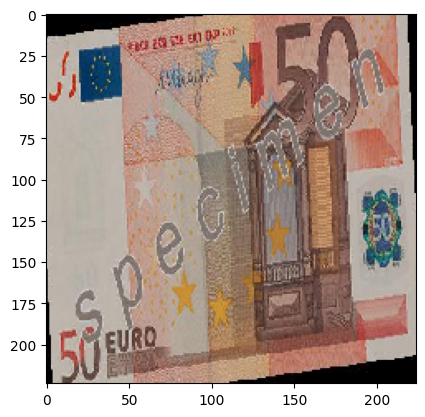

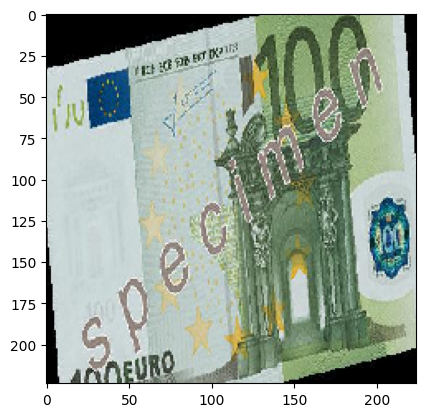

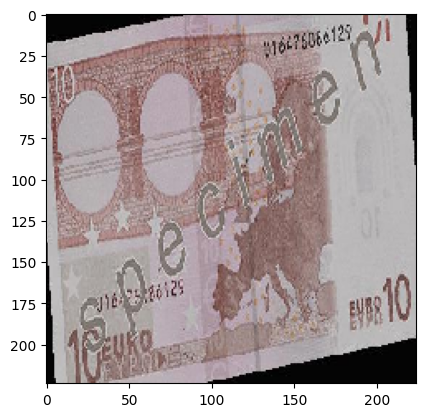

In [11]:
visualize_generator_samples_by_batch(validation_generator, 0)

Load pre-trained model

In [12]:
from keras.applications.resnet50 import ResNet50

base = ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 0s 0us/step


Disable `trainable` for pre-trained layers

In [13]:
for layer in base.layers:
  layer.trainable = False

Adjust the pre-trained model to owns need

In [14]:
import keras
from keras.models import Model

# get pre-trained layers until the second last layer
sec_last_base = base.layers[-2].output

base_input = base.input
connected_model = keras.layers.Dense(len(CLASSES), activation='softmax')(sec_last_base)

model = Model(inputs=base_input, outputs=connected_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

Compile the model

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the model

In [16]:
N_EPOCHS = 20
STEPS = train_generator.n // train_generator.batch_size

model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=STEPS,
                    epochs=N_EPOCHS)

<ipython-input-16-7a670b54072f>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/20
14/14 [==============================] - 13s 126ms/step - loss: 1.7509 - accuracy: 0.4857 - val_loss: 0.9860 - val_accuracy: 0.6857
Epoch 2/20
14/14 [==============================] - 1s 50ms/step - loss: 0.4798 - accuracy: 0.9286 - val_loss: 0.4295 - val_accuracy: 0.9571
Epoch 3/20
14/14 [==============================] - 1s 50ms/step - loss: 0.1924 - accuracy: 1.0000 - val_loss: 0.2255 - val_accuracy: 0.9857
Epoch 4/20
14/14 [==============================] - 1s 49ms/step - loss: 0.0912 - accuracy: 1.0000 - val_loss: 0.1638 - val_accuracy: 0.9857
Epoch 5/20
14/14 [==============================] - 1s 56ms/step - loss: 0.0605 - accuracy: 1.0000 - val_loss: 0.1317 - val_accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 1s 57ms/step - loss: 0.0450 - accuracy: 1.0000 - val_loss: 0.1098 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 1s 50ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.0974 - val_accuracy: 1.0000
Epoch 8/20


Evaluate the result

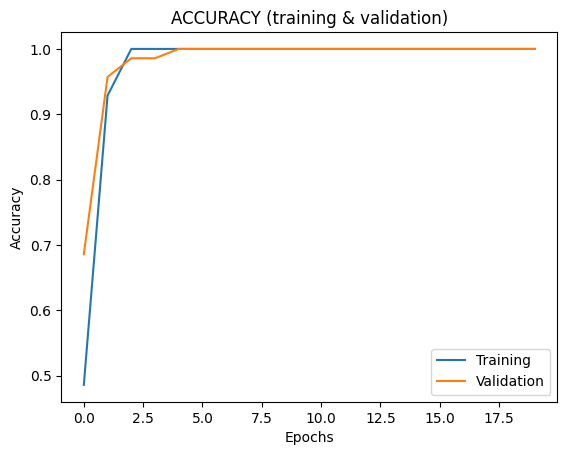

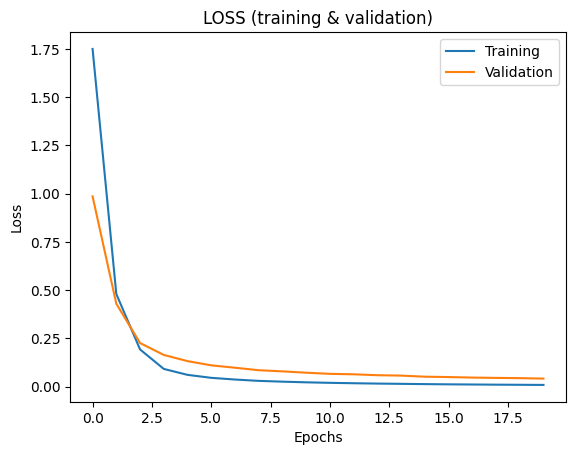

In [17]:
import matplotlib.pyplot as plt

history = model.history

# get data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# get epochs data
epochs = range(len(acc))

# plot accuracy data
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('ACCURACY (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss data
plt.figure()
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('LOSS (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Make ImageDataGenerator for `test` set

In [18]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    classes=CLASSES,
    seed=RANDOM_SEED,
    shuffle=False)

Found 70 images belonging to 7 classes.


<ipython-input-19-4763ba9045f4>:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


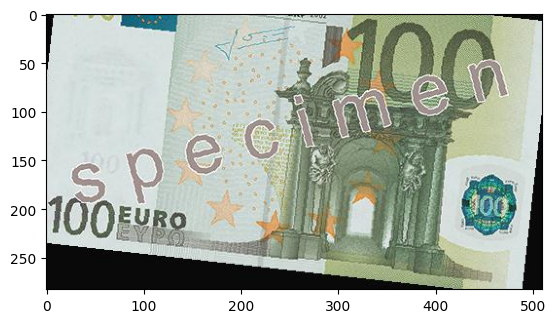

predicted €100 (Correctly Classified)


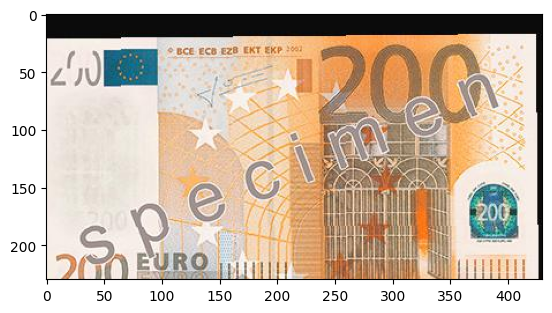

predicted €200 (Correctly Classified)


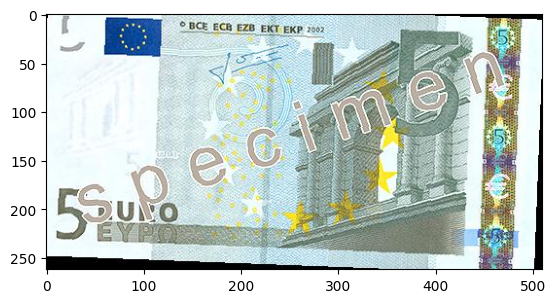

predicted €5 (Correctly Classified)


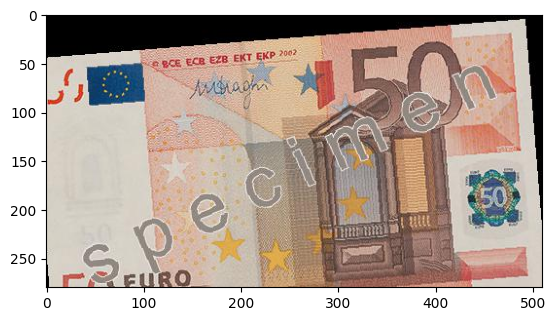

predicted €50 (Correctly Classified)


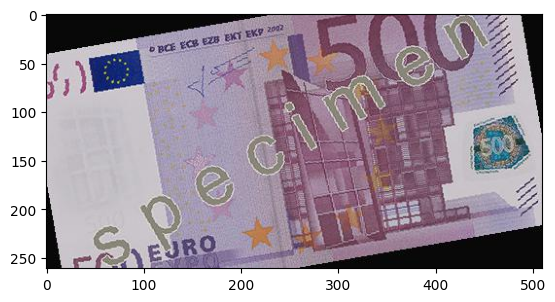

predicted €500 (Correctly Classified)


In [19]:
import random
import matplotlib.image as mpimg

random.seed(0)
numbers = [random.randint(0, 69) for i in range(0, 5)]

# Use MODEL.predict_generator() to make predictions
predictions = model.predict_generator(test_generator)

# Use np.argmax() to find the location of the maximum value
predicted_classes = np.argmax(predictions, axis=1)

# Get the class labels from train_generator.filenames
class_labels = [label.split('/')[-2] for label in test_generator.filenames]

# Get the class indices from train_generator.class_indices
class_indices = test_generator.class_indices

# Match classes with labels
labels = [key for key, value in class_indices.items()]

# Get the true label by analyzing folder name in image resource path
true_labels = [labels.index(label) for label in class_labels]

# Compare, plot, and print results
for i, idx in enumerate(numbers):
    image_path = os.path.join(test_dir, test_generator.filenames[idx])
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.show()

    predict_text = f"predicted €{labels[predicted_classes[idx]]}"
    if predicted_classes[idx] == true_labels[idx]:
        print(f"{predict_text} (Correctly Classified)")
    else:
        print(f"{predict_text} (Mis-classified)")

Make 2nd model using VGG16

In [20]:
from keras.applications.vgg16 import VGG16

base_vgg = VGG16()

553467096/553467096 [==============================] - 3s 0us/step


Disable trainable for pre-trained layers

In [21]:
for layer in base_vgg.layers:
  layer.trainable = False

Adjust the pre-trained model to owns need

In [22]:
sec_last_base_vgg = base_vgg.layers[-2].output

base_input_vgg = base_vgg.input
connected_model_vgg = keras.layers.Dense(len(CLASSES), activation='softmax')(sec_last_base_vgg)

model_vgg = Model(inputs=base_input_vgg, outputs=connected_model_vgg)
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Compile the model

In [23]:
model_vgg.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

Train the model

In [24]:
N_EPOCHS_VGG = 5

model_vgg.fit_generator(generator=train_generator,
                       validation_data=validation_generator,
                       steps_per_epoch=STEPS,
                       epochs=N_EPOCHS_VGG)

Epoch 1/5


<ipython-input-24-15f37ed7a498>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_vgg.fit_generator(generator=train_generator,


14/14 [==============================] - 4s 89ms/step - loss: 2.5666 - accuracy: 0.3714 - val_loss: 0.9636 - val_accuracy: 0.5857
Epoch 2/5
14/14 [==============================] - 1s 69ms/step - loss: 0.2060 - accuracy: 0.9429 - val_loss: 0.1546 - val_accuracy: 0.9571
Epoch 3/5
14/14 [==============================] - 1s 71ms/step - loss: 0.0324 - accuracy: 1.0000 - val_loss: 0.0671 - val_accuracy: 0.9857
Epoch 4/5
14/14 [==============================] - 1s 70ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0730 - val_accuracy: 0.9857
Epoch 5/5
14/14 [==============================] - 1s 71ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9857


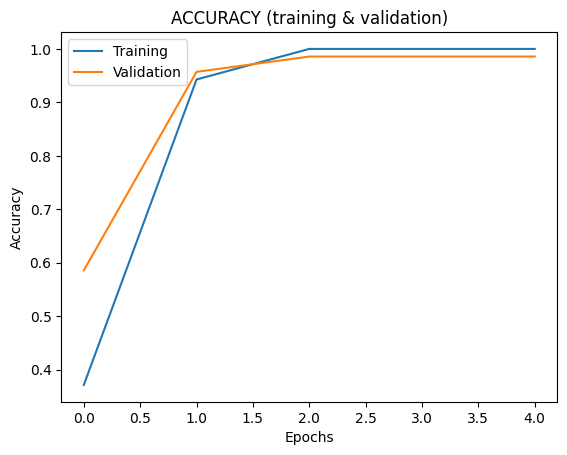

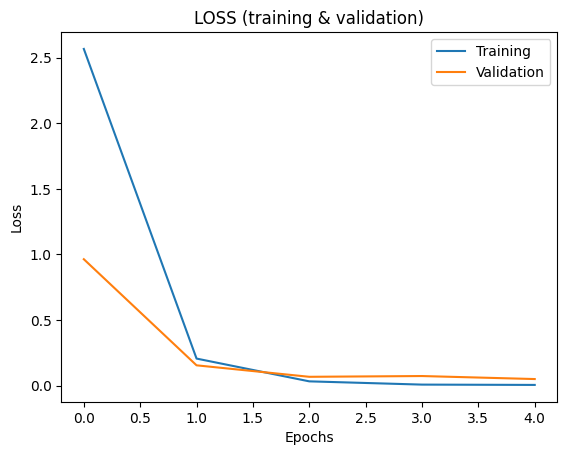

In [25]:
import matplotlib.pyplot as plt

history_vgg = model_vgg.history

# get data from history
acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

# get epochs data
epochs = range(len(acc))

# plot accuracy data
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('ACCURACY (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plot loss data
plt.figure()
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('LOSS (training & validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Save the trained models

In [26]:
model.save("resnet50_keras.pt")
model_vgg.save("vgg16_keras.pt")